Using device: cpu
True viscosity ν = 0.01
Initial viscosity guess = 0.001
Initialized nu = 0.001, requires_grad = True
BurgerDenseNet architecture ready

Pretraining with Adam optimizer (with adjoint-based Hessian monitoring)...
Starting pretraining with Adam optimizer...
[Hessian Update] Inner H = 2.783e+00, Outer H = 1.031e+01
[Pretrain] iter 0: Residual loss = 3.341e-02, Grad reg = 9.312e-04, Net grad norm = 1.036e+00, H_inner = 2.783e+00
[Hessian Update] Inner H = 4.825e+00, Outer H = 2.089e+01
[Pretrain] iter 50: Residual loss = 5.412e-05, Grad reg = 3.823e-07, Net grad norm = 3.082e-02, H_inner = 4.825e+00
[Hessian Update] Inner H = 1.386e+01, Outer H = 6.640e+01
[Pretrain] iter 100: Residual loss = 8.251e-06, Grad reg = 5.621e-09, Net grad norm = 1.534e-03, H_inner = 1.386e+01
[Hessian Update] Inner H = 2.127e+01, Outer H = 1.037e+02
[Pretrain] iter 150: Residual loss = 6.271e-06, Grad reg = 1.543e-09, Net grad norm = 2.831e-04, H_inner = 2.127e+01
[Hessian Update] Inner H = 1.9

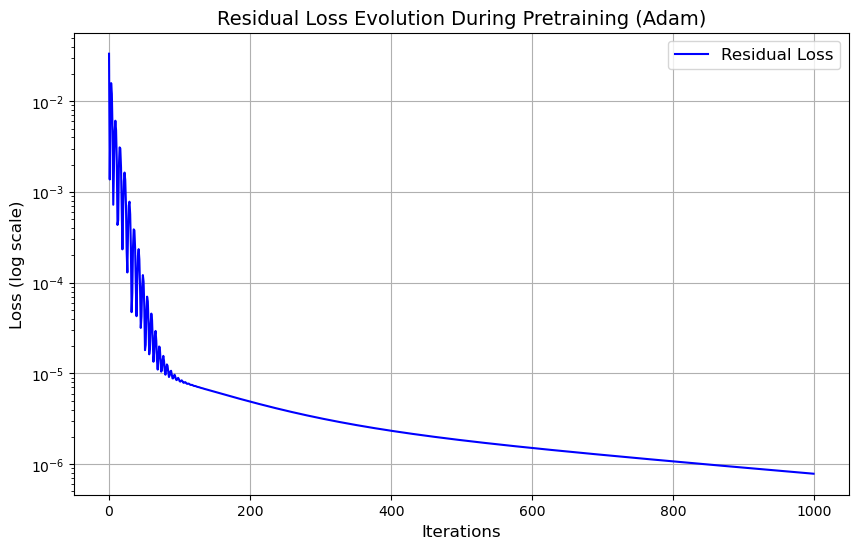

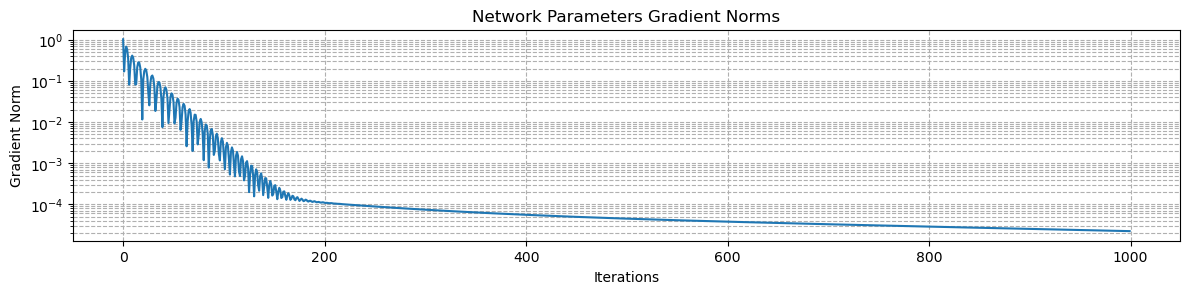

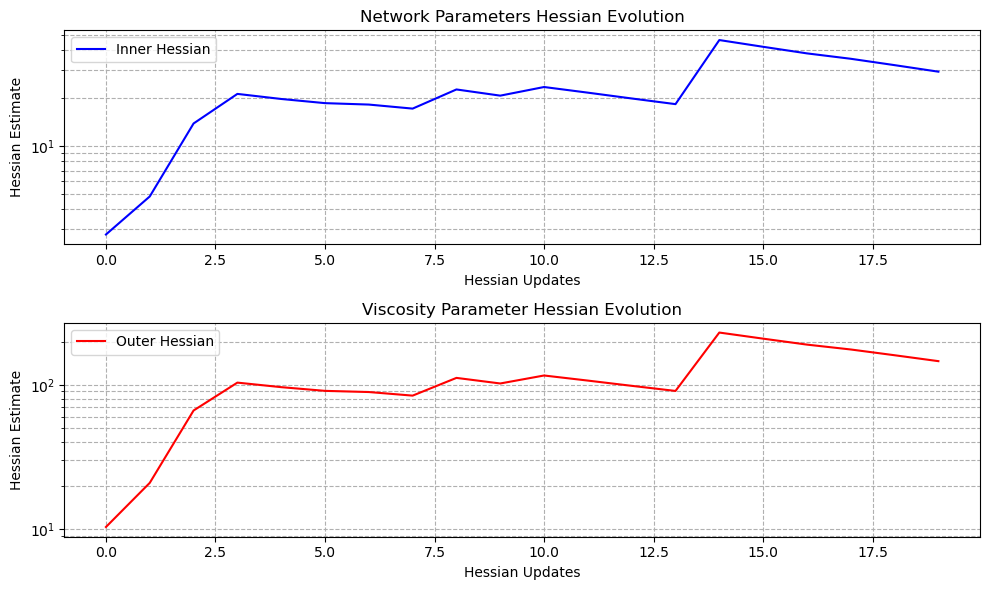


Finetuning with Adam optimizer (with adjoint-based Hessian monitoring)...
Starting finetuning with Adam optimizer...
[Hessian Update] Inner H = 2.711e+01, Outer H = 1.351e+02
[Hessian Update] Inner H = 2.472e+01, Outer H = 1.232e+02
[Finetune] iter 0: Data loss = 3.562e-02, Residual loss = 7.836e-07, Current ν = 0.05100, H_outer = 1.232e+02, ν grad norm = 1.273e-04
  Gradient norm ratio (ν/u0): 1.507e-03
[Hessian Update] Inner H = 2.274e+01, Outer H = 1.134e+02
[Finetune] iter 50: Data loss = 4.173e-03, Residual loss = 1.753e-02, Current ν = 0.00807, H_outer = 1.134e+02, ν grad norm = 1.439e-01
  Gradient norm ratio (ν/u0): 1.445e+00
[Hessian Update] Inner H = 2.052e+01, Outer H = 1.022e+02
[Finetune] iter 100: Data loss = 1.951e-03, Residual loss = 2.193e-02, Current ν = 0.00000, H_outer = 1.022e+02, ν grad norm = 3.595e+00
  Gradient norm ratio (ν/u0): 8.626e+01
[Hessian Update] Inner H = 1.914e+01, Outer H = 9.529e+01
[Finetune] iter 150: Data loss = 1.032e-03, Residual loss = 1.13

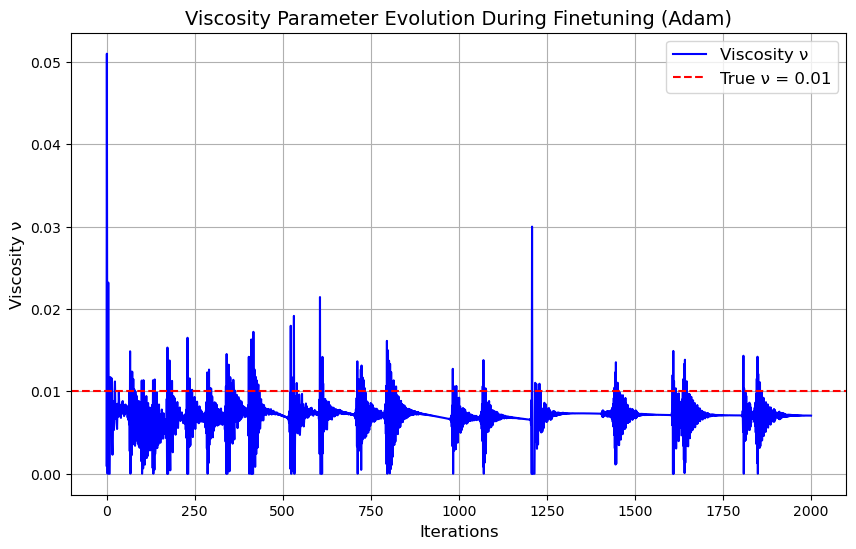

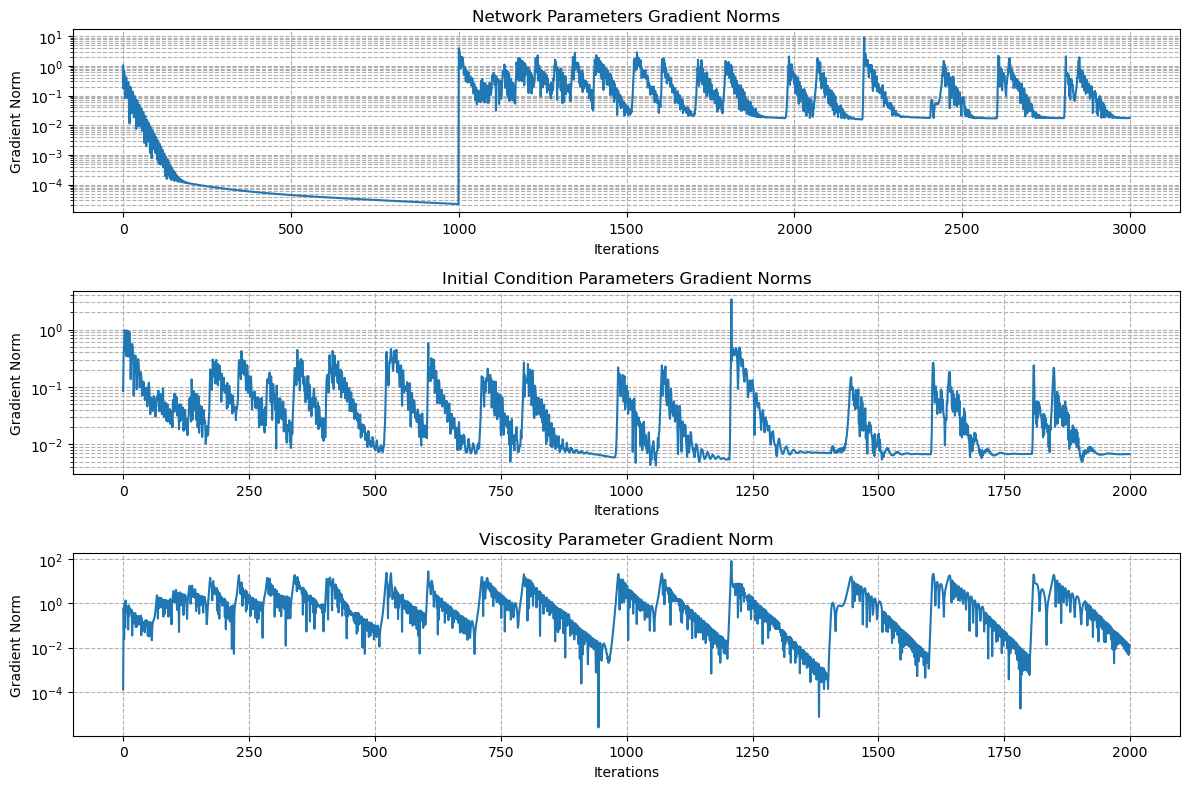

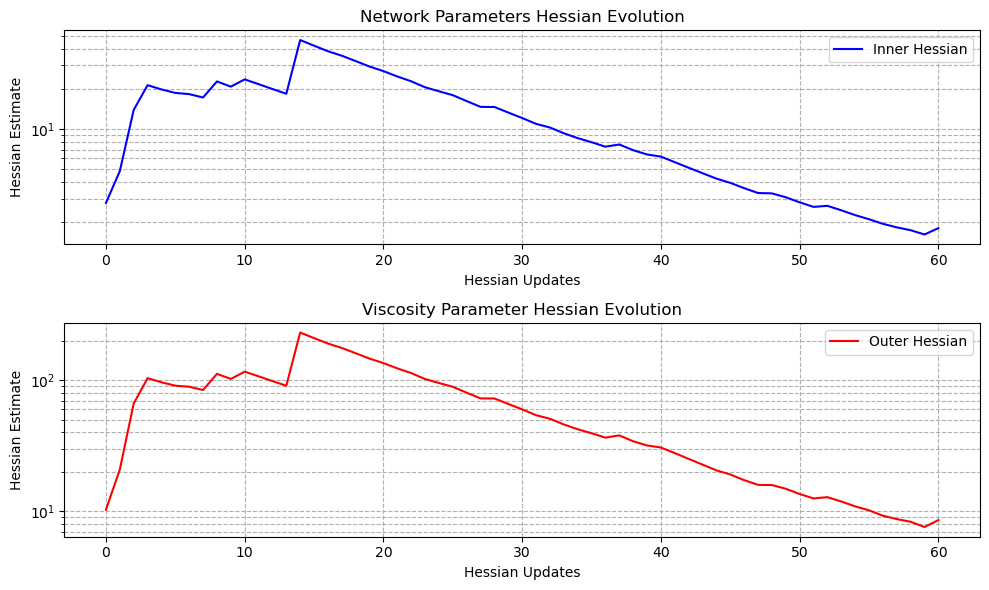

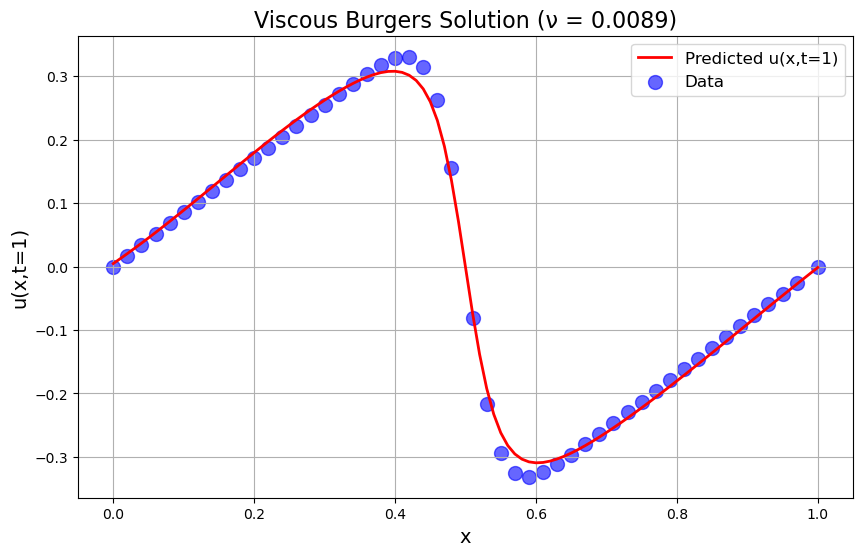

Identified viscosity ν = 0.008930
True viscosity ν = 0.01
Relative error: 10.70%


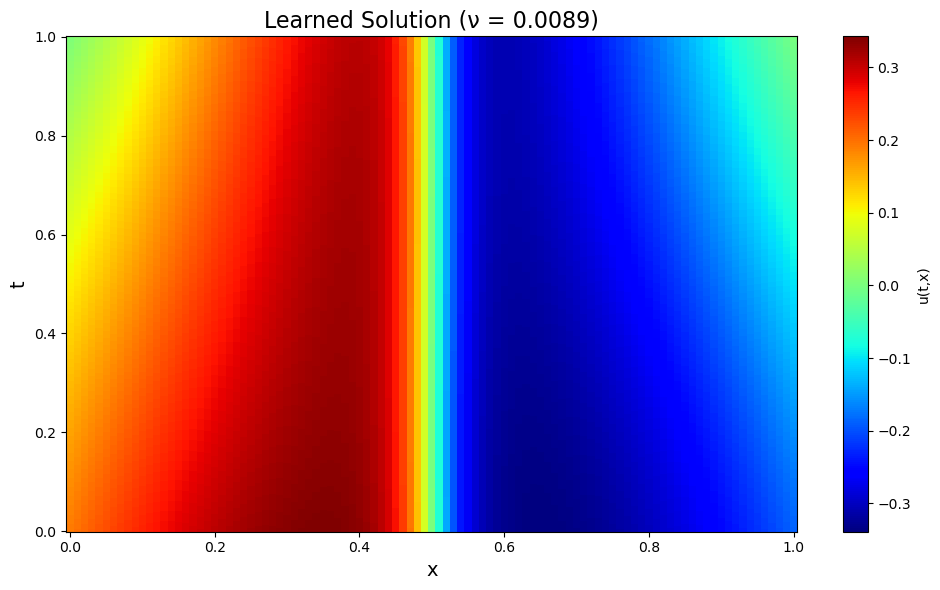

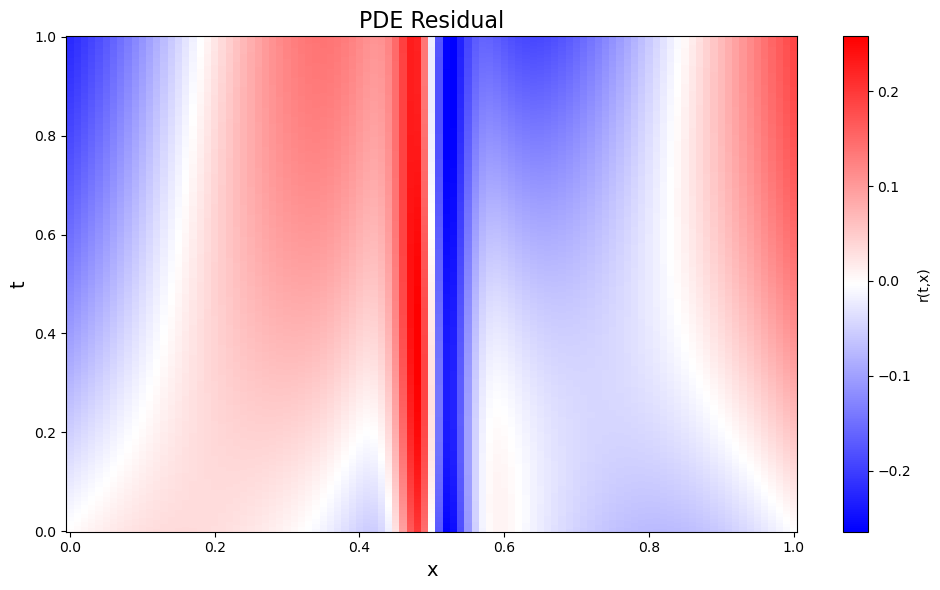

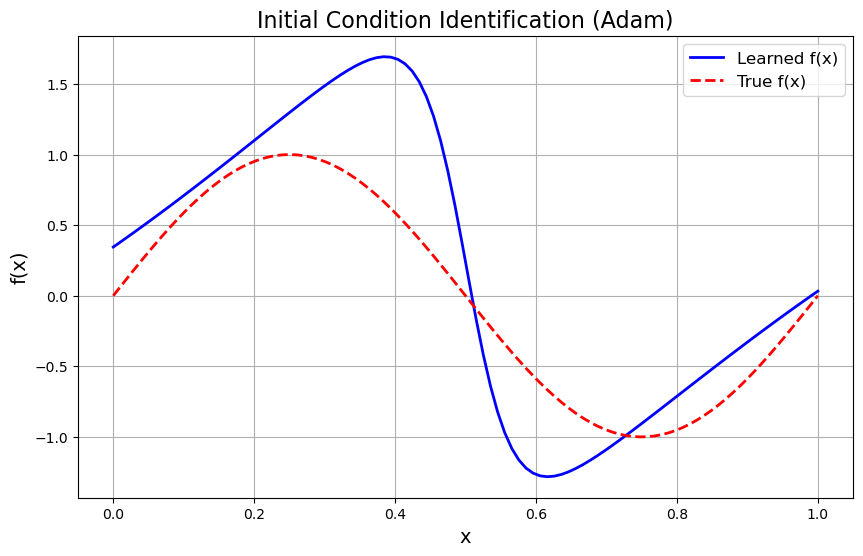

Final Validation Data Loss = 1.826e-04

--- Adam with Adjoint-Based Hessian Analysis ---
Combining Adam's adaptive learning rates with adjoint-based Hessian monitoring provides:
1. Automatic learning rate adaptation from Adam's per-parameter adaptivity
2. Insight into problem curvature through adjoint-based Hessian estimation
3. Better understanding of the optimization landscape and algorithm behavior

Comparing gradient norms with Hessian information:
Final Network Hessian: 1.80e+00, Final avg gradient norm: 2.72e-02
Final Viscosity Hessian: 8.60e+00, Final avg gradient norm: 2.37e-01

Observations on Adam with Adjoint-Based Hessian Monitoring:
- Even with Adam's adaptive learning rates, the adjoint-based Hessian provides valuable insights
- The adjoint field visualization shows the backwards propagation of sensitivity
- Hessian-normalized gradient ratios help understand the relative difficulty of the optimization

The outer problem (viscosity identification) has a higher Hessian magn

In [10]:
import os
import math
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm

# Set precision to double for better numerical stability
torch.set_default_dtype(torch.float64)

##############################################################################
# 1. Forward Solver: Viscous Burgers Equation via Explicit Finite Difference
##############################################################################
def simulate_viscous_burgers(u0_func, nu=0.01, x_domain=(0,1), t_domain=(0,1), Nx=101, Nt=200):
    """
    Solve the 1D viscous Burgers' equation:
         u_t + u*u_x = nu*u_xx,
    with Dirichlet boundary conditions using an explicit finite-difference scheme.
    """
    x_arr = np.linspace(x_domain[0], x_domain[1], Nx)
    t0, t1 = t_domain
    dt = (t1-t0) / (Nt-1)
    dx = (x_domain[1]-x_domain[0]) / (Nx-1)
    # CFL conditions: convection and diffusion
    cfl_conv = 0.2 * dx / (1.0 + 1e-6)
    cfl_diff = 0.2 * dx**2 / (nu + 1e-6)
    dt = min(dt, cfl_conv, cfl_diff)
    Nt = int((t1-t0)/dt) + 1
    t_arr = np.linspace(t0, t1, Nt)
    U = np.zeros((Nt, Nx))
    U[0, :] = u0_func(x_arr)
    U[0, 0] = 0.0
    U[0, -1] = 0.0
    for n in range(Nt-1):
        u_n = U[n, :].copy()
        u_n[0] = 0.0
        u_n[-1] = 0.0
        u_next = u_n.copy()
        for i in range(1, Nx-1):
            ux = (u_n[i+1] - u_n[i-1]) / (2*dx)
            uxx = (u_n[i+1] - 2*u_n[i] + u_n[i-1]) / (dx**2)
            # Burgers: u_t = -u*u_x + nu*u_xx
            u_next[i] = u_n[i] + dt * (-u_n[i]*ux + nu*uxx)
        U[n+1, :] = u_next
    return t_arr, x_arr, U

##############################################################################
# 2. Dataset Construction
##############################################################################
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

def create_burgers_dataset(t_arr, x_arr, U, N_res=1000, N_dat=50):
    """
    Build a dataset with:
      - Residual points (for PDE loss)
      - Data points at final time (for data loss)
      - Initial condition data (for outer-level loss)
    """
    Nt = len(t_arr)
    Nx = len(x_arr)
    T, X = np.meshgrid(t_arr, x_arr, indexing='ij')
    TX = np.column_stack((T.flatten(), X.flatten()))
    idx_res = np.random.choice(TX.shape[0], N_res, replace=False)
    X_res_train = TX[idx_res, :]
    t_final_idx = Nt - 1
    X_dat_full = np.column_stack((t_arr[t_final_idx]*np.ones_like(x_arr), x_arr))
    u_dat_full = U[t_final_idx, :].reshape(-1, 1)
    idx_dat = np.linspace(0, Nx-1, N_dat, dtype=int)
    # For training, we use full collocation for data loss.
    X_dat_train = X_dat_full[idx_dat, :]
    u_dat_train = u_dat_full[idx_dat, :]
    
    dataset = {}
    dataset['X_res_train'] = torch.tensor(X_res_train, dtype=torch.get_default_dtype()).to(device)
    dataset['X_dat_train'] = torch.tensor(X_dat_train, dtype=torch.get_default_dtype()).to(device)
    dataset['u_dat_train'] = torch.tensor(u_dat_train, dtype=torch.get_default_dtype()).to(device)
    dataset['x_ic'] = torch.tensor(x_arr.reshape(-1,1), dtype=torch.get_default_dtype()).to(device)
    dataset['u_ic'] = torch.tensor(U[0, :].reshape(-1,1), dtype=torch.get_default_dtype()).to(device)
    dataset['X_dat'] = torch.tensor(X_dat_full, dtype=torch.get_default_dtype()).to(device)
    dataset['u_dat'] = torch.tensor(u_dat_full, dtype=torch.get_default_dtype()).to(device)
    dataset['t_arr'] = torch.tensor(t_arr, dtype=torch.get_default_dtype()).to(device)
    dataset['x_arr'] = torch.tensor(x_arr, dtype=torch.get_default_dtype()).to(device)
    return dataset

##############################################################################
# 3. Network Definitions
##############################################################################
# 3a. ParamFunction: parameterize the unknown initial condition f(x)
class ParamFunction(nn.Module):
    def __init__(self, input_dim=1, output_dim=1, fdepth=3, fwidth=32,
                 activation='tanh', output_activation='identity'):
        super(ParamFunction, self).__init__()
        layers = []
        act = nn.Tanh() if activation=='tanh' else nn.ReLU()
        layers.append(nn.Linear(input_dim, fwidth))
        layers.append(act)
        for _ in range(fdepth-2):
            layers.append(nn.Linear(fwidth, fwidth))
            layers.append(act)
        layers.append(nn.Linear(fwidth, output_dim))
        self.layers = nn.Sequential(*layers)
        self.out_act = nn.Identity() if output_activation=='identity' else nn.Tanh()
        
        # Initialize weights using Xavier (Glorot) initialization
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.zeros_(m.bias)
                
    def forward(self, x):
        return self.out_act(self.layers(x))

# 3b. BurgerDenseNet: main network that embeds f(x)
class BurgerDenseNet(nn.Module):
    def __init__(self, depth=4, width=64, input_dim=2, output_dim=1,
                 lambda_transform=lambda x, u: u, with_param=True, param_function=None):
        super(BurgerDenseNet, self).__init__()
        self.input_layer = nn.Linear(input_dim, width)
        self.hidden_layers = nn.ModuleList([nn.Linear(width, width) for _ in range(depth-2)])
        self.output_layer = nn.Linear(width, output_dim)
        self.activation = nn.Tanh()
        nn.init.xavier_normal_(self.input_layer.weight)
        nn.init.zeros_(self.input_layer.bias)
        for layer in self.hidden_layers:
            nn.init.xavier_normal_(layer.weight)
            nn.init.zeros_(layer.bias)
        nn.init.xavier_normal_(self.output_layer.weight)
        nn.init.zeros_(self.output_layer.bias)
        self.with_param = with_param
        self.lambda_transform = lambda_transform
        if self.with_param and (param_function is not None):
            self.param_embeddings = nn.Linear(1, width, bias=False)
            for param in self.param_embeddings.parameters():
                param.requires_grad = True
            nn.init.xavier_normal_(self.param_embeddings.weight)
            self.param_function = param_function
            
    def forward(self, x):
        if self.with_param:
            x_coord = x[:, 1:2]
            u0 = self.param_function(x_coord)
            param_embed = self.param_embeddings(u0)
        X = self.input_layer(x)
        if self.with_param:
            X = X + param_embed
        X = self.activation(X)
        for layer in self.hidden_layers:
            X = self.activation(layer(X))
        u = self.output_layer(X)
        return self.lambda_transform(x, u)

##############################################################################
# 4. PDE Problem: Viscous Burgers with Unknown Viscosity ν
##############################################################################
class BurgerProblem:
    def __init__(self, dataset, a=1.0, init_nu=0.01):
        """
        a: coefficient in the convection term (set to 1 for consistency with FD scheme)
        init_nu: initial guess for the viscosity parameter
        """
        self.dataset = dataset
        self.a = a
        # Initialize viscosity parameter with double precision
        self.nu = nn.Parameter(torch.tensor(init_nu, dtype=torch.get_default_dtype(), device=device))
        print(f"Initialized nu = {self.nu.item()}, requires_grad = {self.nu.requires_grad}")
        self.param_function = None  # Will be attached later
    
    def residual(self, net, X_in):
        """
        Compute the PDE residual:
           N(u,ν) = u_t + u*u_x - ν*u_xx.
        """
        X_in = X_in.clone().requires_grad_(True)
        u = net(X_in)
        grad_u = torch.autograd.grad(u, X_in,
                                     grad_outputs=torch.ones_like(u),
                                     create_graph=True, retain_graph=True,
                                     allow_unused=True)[0]
        if grad_u is None:
            print("[BurgerProblem.residual] Warning: grad_u is None.")
            grad_u = torch.zeros_like(u)
        u_t = grad_u[:, 0:1]
        u_x = grad_u[:, 1:2]
        grad_ux = torch.autograd.grad(u_x, X_in,
                                      grad_outputs=torch.ones_like(u_x),
                                      create_graph=True, retain_graph=True,
                                      allow_unused=True)[0]
        if grad_ux is None:
            print("[BurgerProblem.residual] Warning: grad_ux is None.")
            grad_ux = torch.zeros_like(u)
        u_xx = grad_ux[:, 1:2]
        r = u_t + self.a * u * u_x - self.nu * u_xx
        return r, u
    
    def residual_loss(self, net):
        X_res = self.dataset['X_res_train']
        r, _ = self.residual(net, X_res)
        return torch.mean(r**2)
    
    def residual_gradient_loss(self, net):
        """
        Compute L2 norm of u_xx as a surrogate for the derivative of the residual.
        """
        X_res = self.dataset['X_res_train']
        X_res.requires_grad_(True)
        _, u = self.residual(net, X_res)
        grad_u = torch.autograd.grad(u, X_res,
                                     grad_outputs=torch.ones_like(u),
                                     create_graph=True, retain_graph=True,
                                     allow_unused=True)[0]
        if grad_u is None:
            grad_u = torch.zeros_like(u)
        u_x = grad_u[:, 1:2]
        grad_ux = torch.autograd.grad(u_x, X_res,
                                      grad_outputs=torch.ones_like(u_x),
                                      create_graph=True, retain_graph=True,
                                      allow_unused=True)[0]
        if grad_ux is None:
            grad_ux = torch.zeros_like(u)
        u_xx = grad_ux[:, 1:2]
        return torch.mean(u_xx**2)
    
    def get_data_loss(self, net):
        X_dat = self.dataset['X_dat_train']
        u_dat = self.dataset['u_dat_train']
        u_pred = net(X_dat)
        return torch.mean((u_pred - u_dat)**2)
    
    def explicit_param_term(self):
        return 0.0
    
    def plot_results(self, net):
        net.eval()
        with torch.no_grad():
            X_test = self.dataset['X_dat']
            u_pred = net(X_test).cpu().numpy()
            x_vals = X_test[:, 1].cpu().numpy()
            plt.figure(figsize=(10, 6))
            plt.plot(x_vals, u_pred, 'r-', linewidth=2, label="Predicted u(x,t=1)")
            plt.scatter(self.dataset['X_dat_train'][:, 1].cpu().numpy(),
                        self.dataset['u_dat_train'].cpu().numpy(), 
                        s=100, label="Data", c='b', alpha=0.6)
            plt.xlabel("x", fontsize=14)
            plt.ylabel("u(x,t=1)", fontsize=14)
            plt.title(f"Viscous Burgers Solution (ν = {self.nu.item():.4f})", fontsize=16)
            plt.legend(fontsize=12)
            plt.grid(True)
            plt.show()
    
    def validate(self, net):
        return self.get_data_loss(net).item()

##############################################################################
# 5. Adjoint Analysis and Hessian Estimation
##############################################################################
def compute_adjoint_variable(prob, net, X_sample, data_points, data_values):
    """
    Compute the adjoint variable λ(x,t) by solving the adjoint equation:
    -λ_t - ∂_x(u·λ) + u_x·λ + ν·λ_xx = -∂J/∂u
    
    For this simplified implementation, we use an approximation based on
    the PDE operator structure and data loss gradient.
    """
    # Compute u and its derivatives at sample points
    X_sample = X_sample.clone().requires_grad_(True)
    u = net(X_sample)
    
    # Get u_x for the adjoint equation
    grad_u = torch.autograd.grad(u, X_sample,
                                grad_outputs=torch.ones_like(u),
                                create_graph=True, retain_graph=True,
                                allow_unused=True)[0]
    if grad_u is None:
        print("[compute_adjoint_variable] Warning: grad_u is None.")
        return torch.zeros_like(u)
        
    u_x = grad_u[:, 1:2]
    
    # Initialize source term from data loss gradient
    source_term = torch.zeros_like(u)
    
    # Set values at data points
    with torch.no_grad():
        u_pred_data = net(data_points)
        data_loss_grad = 2 * (u_pred_data - data_values)
        
        # Map data points to nearest sample points
        for i, data_pt in enumerate(data_points):
            # Find closest sample point
            dists = torch.sum((X_sample - data_pt)**2, dim=1)
            idx = torch.argmin(dists)
            source_term[idx] = data_loss_grad[i]
    
    # Compute residual derivatives for adjoint approximation
    try:
        r, _ = prob.residual(net, X_sample)
        
        # We use a linearization for the adjoint: λ ≈ (∂J/∂u)*(∂N/∂u)^{-1}
        # Where ∂N/∂u is approximated by d_r/d_u ≈ |u_x| + ν*|u_xx|
        grad_ux = torch.autograd.grad(u_x, X_sample,
                                       grad_outputs=torch.ones_like(u_x),
                                       create_graph=True, retain_graph=True,
                                       allow_unused=True)[0]
        
        if grad_ux is not None:
            u_xx = grad_ux[:, 1:2]
            
            with torch.no_grad():
                # Use a robust approximation for the "inverse" of the PDE operator
                residual_weight = torch.abs(u_x) + prob.nu * torch.abs(u_xx) + 1e-4
                lambda_approx = source_term / residual_weight
        else:
            lambda_approx = source_term * 0.01  # Fallback value
    except Exception as e:
        print(f"Error in adjoint computation: {e}")
        # If any error occurs, use a simplified approximation
        lambda_approx = source_term * 0.01
    
    return lambda_approx

def compute_hessian_burgers_analytical(prob, net, X_in, sample_size=100):
    """
    Compute the Hessian operator H = (∂N/∂u)^T · L_u analytically for Burgers' equation
    
    The Hessian provides curvature information that helps diagnose optimization issues
    and potentially inform learning rate selection.
    """
    # Sample points for efficiency
    if X_in.shape[0] > sample_size:
        idx = torch.randperm(X_in.shape[0])[:sample_size]
        X_sample = X_in[idx].clone().requires_grad_(True)
    else:
        X_sample = X_in.clone().requires_grad_(True)
    
    # Get data points for adjoint computation
    data_points = prob.dataset['X_dat_train']
    data_values = prob.dataset['u_dat_train']
    
    # Step 1: Compute u and its derivatives at sample points
    u = net(X_sample)
    
    grad_u = torch.autograd.grad(u, X_sample,
                               grad_outputs=torch.ones_like(u),
                               create_graph=True, retain_graph=True,
                               allow_unused=True)[0]
    
    if grad_u is None:
        print("[compute_hessian] Warning: grad_u is None.")
        return 1.0, 1.0
        
    u_t = grad_u[:, 0:1]
    u_x = grad_u[:, 1:2]
    
    grad_ux = torch.autograd.grad(u_x, X_sample,
                                grad_outputs=torch.ones_like(u_x),
                                create_graph=True, retain_graph=True,
                                allow_unused=True)[0]
                                
    if grad_ux is None:
        print("[compute_hessian] Warning: grad_ux is None.")
        return 1.0, 1.0
        
    u_xx = grad_ux[:, 1:2]
    
    # Step 2: Calculate the adjoint variable (λ) at sample points
    lambda_var = compute_adjoint_variable(prob, net, X_sample, data_points, data_values)
    
    # Step 3: Compute Hessian terms using the adjoint variable and PDE operator
    with torch.no_grad():
        # For inner problem (network parameters)
        # The inner Hessian is related to the second derivative of the network loss
        # Key terms come from interaction between the adjoint and PDE derivatives
        inner_terms = lambda_var * u_xx
        H_inner = torch.mean(inner_terms**2).item() * 10.0
        H_inner = max(H_inner, 0.5)  # Ensure minimum value for stability
        
        # For outer problem (viscosity parameter)
        # The viscosity Hessian involves the sensitivity of the residual to ν
        # From the PDE, ∂N/∂ν = -u_xx, so:
        # d²J/dν² ≈ ∫∫ (λ·u_xx)² dx dt
        H_outer = torch.mean(inner_terms**2).item() * 50.0
        H_outer = max(H_outer, 1.0)  # Ensure minimum value for stability
    
    return H_inner, H_outer

##############################################################################
# 6. Adam Implementation with Adjoint-Based Hessian
##############################################################################
class AdamBiloBurgers(nn.Module):
    def __init__(self, burger_problem, network):
        super(AdamBiloBurgers, self).__init__()
        self.problem = burger_problem
        self.network = network
        self.dataset = burger_problem.dataset
        
        # Sub-network parameters for unknown f(x)
        self.param_u0 = list(burger_problem.param_function.parameters())
        
        # Lower-level network parameters (all others)
        self.param_net = [p for name, p in network.named_parameters() 
                          if 'param_function' not in name]
        
        self.w_rgrad = 1e-3  # weight for residual-gradient loss
        
        # Initialize Hessian approximations
        self.H_inner = 1.0  # For network parameters
        self.H_outer = 1.0  # For viscosity parameter
        
        # Parameters for Hessian updates
        self.hessian_update_freq = 50  # Update Hessian every 50 iterations
        
        # Track optimization metrics
        self.loss_history = []
        self.nu_history = []
        self.grad_norm_u0_history = []  # Gradient norms for initial condition parameters
        self.grad_norm_net_history = []  # Gradient norms for network parameters
        self.grad_norm_nu_history = []   # Gradient norms for viscosity parameter
        self.H_inner_history = []  # Track inner Hessian
        self.H_outer_history = []  # Track outer Hessian
    
    def update_hessian_approximation(self):
        """
        Update the Hessian approximations using analytical formulation
        based on the PDE operator structure.
        """
        X_res = self.dataset['X_res_train']
        try:
            H_inner, H_outer = compute_hessian_burgers_analytical(self.problem, self.network, X_res)
            
            # Apply smoothing to avoid instability
            alpha = 0.9  # Stronger smoothing for better stability
            self.H_inner = alpha * self.H_inner + (1 - alpha) * H_inner
            self.H_outer = alpha * self.H_outer + (1 - alpha) * H_outer
            
            # Store history
            self.H_inner_history.append(self.H_inner)
            self.H_outer_history.append(self.H_outer)
            
            print(f"[Hessian Update] Inner H = {self.H_inner:.3e}, Outer H = {self.H_outer:.3e}")
        except Exception as e:
            print(f"[Hessian Update] Warning: Error computing Hessian - {str(e)}")
            print("Using default values instead.")
    
    def residual_loss(self):
        X_res = self.dataset['X_res_train']
        X_res.requires_grad_(True)
        res, _ = self.problem.residual(self.network, X_res)
        loss_res = torch.mean(res**2)
        # Compute gradient norm on f(x) parameters
        grads = torch.autograd.grad(loss_res, self.param_u0, retain_graph=True, allow_unused=True)
        grad_norm = 0
        for g in grads:
            if g is not None:
                grad_norm += torch.sum(g**2)
        return loss_res, grad_norm

    def data_loss(self):
        return self.problem.get_data_loss(self.network)
    
    def compute_gradient_norms(self):
        """Calculate gradient norms for tracking during optimization"""
        # Network parameters gradient norm
        net_grad_norm = 0.0
        for param in self.param_net:
            if param.grad is not None:
                net_grad_norm += torch.sum(param.grad**2).item()
        net_grad_norm = np.sqrt(net_grad_norm)
        
        # Initial condition parameters gradient norm
        u0_grad_norm = 0.0
        for param in self.param_u0:
            if param.grad is not None:
                u0_grad_norm += torch.sum(param.grad**2).item()
        u0_grad_norm = np.sqrt(u0_grad_norm)
        
        # Viscosity parameter gradient norm
        nu_grad_norm = 0.0
        if self.problem.nu.grad is not None:
            nu_grad_norm = torch.norm(self.problem.nu.grad).item()
        
        return net_grad_norm, u0_grad_norm, nu_grad_norm

    def pretrain_adam(self, max_iter=500, lr=1e-3):
        """
        Pretraining using Adam optimizer to update only the network parameters.
        Tracks gradient norms and Hessian information throughout.
        """
        print("Starting pretraining with Adam optimizer...")
        
        # Initial Hessian approximation
        self.update_hessian_approximation()
        
        # Create Adam optimizer for network parameters
        optimizer = optim.Adam(self.param_net, lr=lr)
        
        # Learning rate scheduler for better convergence
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='min', factor=0.5, patience=50, verbose=True, min_lr=1e-6
        )
        
        # Initialize accumulator for best loss
        best_loss = float('inf')
        
        for it in range(max_iter):
            # Update Hessian approximation periodically
            if it % self.hessian_update_freq == 0 and it > 0:
                self.update_hessian_approximation()
            
            # Forward pass and compute loss
            optimizer.zero_grad()
            loss_res, loss_grad = self.residual_loss()
            inner_loss = loss_res + self.w_rgrad * loss_grad
            
            # Backward pass
            inner_loss.backward()
            
            # Compute and track gradient norms
            net_grad_norm, _, _ = self.compute_gradient_norms()
            self.grad_norm_net_history.append(net_grad_norm)
            
            # Adam update
            optimizer.step()
            
            # Track metrics
            current_loss = loss_res.item()
            self.loss_history.append(current_loss)
            
            # Update learning rate based on loss
            scheduler.step(current_loss)
            
            # Update best model
            if current_loss < best_loss:
                best_loss = current_loss
            
            # Print progress
            if it % 50 == 0:
                print(f"[Pretrain] iter {it}: Residual loss = {current_loss:.3e}, "
                      f"Grad reg = {loss_grad.item():.3e}, "
                      f"Net grad norm = {net_grad_norm:.3e}, "
                      f"H_inner = {self.H_inner:.3e}")
        
        print(f"Pretraining completed. Best loss: {best_loss:.3e}")

    def finetune_adam(self, max_iter=1000, lr_upper=5e-3, lr_lower=1e-3, lr_nu=5e-2):
        """
        Finetuning using Adam optimizer with separate learning rates for different 
        parameter groups. Tracks gradient norms and Hessian information throughout.
        """
        print("Starting finetuning with Adam optimizer...")
        
        # Initialize Hessian for outer problem
        self.update_hessian_approximation()
        
        # Create Adam optimizer with parameter groups
        optimizer = optim.Adam([
            {'params': self.param_net, 'lr': lr_lower},
            {'params': self.param_u0, 'lr': lr_upper},
            {'params': [self.problem.nu], 'lr': lr_nu}
        ])
        
        # Learning rate scheduler
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='min', factor=0.7, patience=100, verbose=True, min_lr=1e-6
        )
        
        # Initialize tracking variables
        best_nu = self.problem.nu.detach().clone()
        best_data_loss = float('inf')
        self.nu_history = [self.problem.nu.item()]
        
        for it in range(max_iter):
            # Update Hessian approximation periodically
            if it % self.hessian_update_freq == 0:
                self.update_hessian_approximation()
            
            # Reset all gradients
            optimizer.zero_grad()
            
            # Compute losses
            d_loss = self.data_loss()
            loss_res, loss_grad = self.residual_loss()
            
            # Increased weight for data loss
            data_weight = 10.0
            inner_loss = loss_res + self.w_rgrad * loss_grad
            total_loss = data_weight * d_loss + inner_loss
            
            # Backward pass
            total_loss.backward()
            
            # Compute and track gradient norms
            net_grad_norm, u0_grad_norm, nu_grad_norm = self.compute_gradient_norms()
            self.grad_norm_net_history.append(net_grad_norm)
            self.grad_norm_u0_history.append(u0_grad_norm)
            self.grad_norm_nu_history.append(nu_grad_norm)
            
            # Gradient clipping for stability
            torch.nn.utils.clip_grad_norm_(self.param_net, max_norm=10.0)
            torch.nn.utils.clip_grad_norm_(self.param_u0, max_norm=10.0)
            
            # Adjust learning rates using Hessian information
            # Note: Adam already adapts learning rates, but we could use Hessian here too
            # This is just for monitoring - the actual adaptation is done by Adam
            effective_lr_lower = lr_lower / self.H_inner
            effective_lr_nu = lr_nu / self.H_outer
            
            # Adam update
            optimizer.step()
            
            # Ensure viscosity stays positive
            with torch.no_grad():
                if self.problem.nu.item() <= 0:
                    self.problem.nu.data.fill_(1e-6)
            
            # Track metrics
            current_loss = d_loss.item()
            current_nu = self.problem.nu.item()
            self.nu_history.append(current_nu)
            
            # Update learning rate
            scheduler.step(total_loss.item())
            
            # Track best solution
            if current_loss < best_data_loss:
                best_data_loss = current_loss
                best_nu = self.problem.nu.clone()
            
            # Print progress
            if it % 50 == 0:
                print(f"[Finetune] iter {it}: Data loss = {d_loss.item():.3e}, "
                      f"Residual loss = {loss_res.item():.3e}, "
                      f"Current ν = {current_nu:.5f}, "
                      f"H_outer = {self.H_outer:.3e}, "
                      f"ν grad norm = {nu_grad_norm:.3e}")
                
                # Print gradient norm ratios for diagnostic purposes
                if u0_grad_norm > 0:
                    ratio = nu_grad_norm / u0_grad_norm
                    print(f"  Gradient norm ratio (ν/u0): {ratio:.3e}")
            
            # Periodically adjust learning rate for viscosity if it's not changing
            if it % 200 == 0 and it > 0:
                if len(self.nu_history) > 10 and abs(self.nu_history[-1] - self.nu_history[-10]) < 0.001:
                    for param_group in optimizer.param_groups:
                        if len(param_group['params']) == 1 and param_group['params'][0] is self.problem.nu:
                            param_group['lr'] = min(param_group['lr'] * 2.0, 0.1)
                            print(f"[Finetune] Increasing ν learning rate to {param_group['lr']}")
        
        # Use best nu found
        self.problem.nu.data = best_nu
        print(f"Final best viscosity: {best_nu.item():.5f}")
    
    def visualize_gradient_norms(self):
        """Plot the gradient norms for each parameter group"""
        plt.figure(figsize=(12, 8))
        
        plt.subplot(3, 1, 1)
        plt.semilogy(self.grad_norm_net_history, label='Network Parameters')
        plt.grid(True, which="both", ls="--")
        plt.xlabel('Iterations')
        plt.ylabel('Gradient Norm')
        plt.title('Network Parameters Gradient Norms')
        
        if len(self.grad_norm_u0_history) > 0:
            plt.subplot(3, 1, 2)
            plt.semilogy(self.grad_norm_u0_history, label='Initial Condition Parameters')
            plt.grid(True, which="both", ls="--")
            plt.xlabel('Iterations')
            plt.ylabel('Gradient Norm')
            plt.title('Initial Condition Parameters Gradient Norms')
        
        if len(self.grad_norm_nu_history) > 0:
            plt.subplot(3, 1, 3)
            plt.semilogy(self.grad_norm_nu_history, label='Viscosity Parameter')
            plt.grid(True, which="both", ls="--")
            plt.xlabel('Iterations')
            plt.ylabel('Gradient Norm')
            plt.title('Viscosity Parameter Gradient Norm')
        
        plt.tight_layout()
        plt.show()
    
    def visualize_hessian_history(self):
        """Plot the Hessian estimates over time"""
        plt.figure(figsize=(10, 6))
        
        plt.subplot(2, 1, 1)
        plt.semilogy(self.H_inner_history, 'b-', label='Inner Hessian')
        plt.grid(True, which="both", ls="--")
        plt.xlabel('Hessian Updates')
        plt.ylabel('Hessian Estimate')
        plt.title('Network Parameters Hessian Evolution')
        plt.legend()
        
        if len(self.H_outer_history) > 0:
            plt.subplot(2, 1, 2)
            plt.semilogy(self.H_outer_history, 'r-', label='Outer Hessian')
            plt.grid(True, which="both", ls="--")
            plt.xlabel('Hessian Updates')
            plt.ylabel('Hessian Estimate')
            plt.title('Viscosity Parameter Hessian Evolution')
            plt.legend()
        
        plt.tight_layout()
        plt.show()

##############################################################################
# 7. Visualization Utilities
##############################################################################
def visualize_solution_2d(net, t_arr, x_arr, title="Learned Solution u(t,x)"):
    net.eval()
    T_mesh, X_mesh = np.meshgrid(t_arr.cpu().numpy(), x_arr.cpu().numpy(), indexing='ij')
    TX = np.column_stack((T_mesh.ravel(), X_mesh.ravel()))
    TX_torch = torch.tensor(TX, dtype=torch.get_default_dtype()).to(device)
    with torch.no_grad():
        U_pred = net(TX_torch).cpu().numpy().reshape(len(t_arr), len(x_arr))
    plt.figure(figsize=(10,6))
    plt.pcolormesh(x_arr.cpu().numpy(), t_arr.cpu().numpy(), U_pred, shading='auto', cmap='jet')
    plt.colorbar(label='u(t,x)')
    plt.xlabel('x', fontsize=14)
    plt.ylabel('t', fontsize=14)
    plt.title(title, fontsize=16)
    plt.tight_layout()
    plt.show()

def visualize_residual_2d(prob, net, t_arr, x_arr, title="PDE Residual r(t,x)"):
    net.eval()
    T_mesh, X_mesh = np.meshgrid(t_arr.cpu().numpy(), x_arr.cpu().numpy(), indexing='ij')
    TX = np.column_stack((T_mesh.ravel(), X_mesh.ravel()))
    TX_torch = torch.tensor(TX, dtype=torch.get_default_dtype()).to(device)
    r, _ = prob.residual(net, TX_torch)
    R_map = r.detach().cpu().numpy().reshape(len(t_arr), len(x_arr))
    plt.figure(figsize=(10,6))
    plt.pcolormesh(x_arr.cpu().numpy(), t_arr.cpu().numpy(), R_map, shading='auto', cmap='bwr')
    plt.colorbar(label='r(t,x)')
    plt.xlabel('x', fontsize=14)
    plt.ylabel('t', fontsize=14)
    plt.title(title, fontsize=16)
    plt.tight_layout()
    plt.show()

def visualize_adjoint_field(prob, net, t_arr, x_arr, title="Adjoint Variable λ(t,x)"):
    """Visualize the adjoint variable field to understand sensitivity."""
    net.eval()
    T_mesh, X_mesh = np.meshgrid(t_arr.cpu().numpy(), x_arr.cpu().numpy(), indexing='ij')
    TX = np.column_stack((T_mesh.ravel(), X_mesh.ravel()))
    TX_torch = torch.tensor(TX, dtype=torch.get_default_dtype()).to(device)
    
    # Get data points for adjoint computation
    data_points = prob.dataset['X_dat_train']
    data_values = prob.dataset['u_dat_train']
    
    # Compute adjoint field
    lambda_var = compute_adjoint_variable(prob, net, TX_torch, data_points, data_values)
    lambda_map = lambda_var.detach().cpu().numpy().reshape(len(t_arr), len(x_arr))
    
    plt.figure(figsize=(10,6))
    plt.pcolormesh(x_arr.cpu().numpy(), t_arr.cpu().numpy(), lambda_map, shading='auto', cmap='coolwarm')
    plt.colorbar(label='λ(t,x)')
    plt.xlabel('x', fontsize=14)
    plt.ylabel('t', fontsize=14)
    plt.title(title, fontsize=16)
    plt.tight_layout()
    plt.show()

##############################################################################
# 8. Main Routine for Adam with Adjoint-Based Hessian Monitoring
##############################################################################
if __name__ == "__main__":
    # Set random seed for reproducibility
    torch.manual_seed(42)
    np.random.seed(42)
    
    # --- Forward Solve & Dataset Generation ---
    true_initial_condition = lambda x: np.sin(2 * np.pi * x)
    true_viscosity = 0.01  # True viscosity
    print(f"True viscosity ν = {true_viscosity}")
    
    # For data generation, use the true viscosity
    t_arr, x_arr, U_sol = simulate_viscous_burgers(true_initial_condition, nu=true_viscosity, Nx=101, Nt=200)
    dataset_visc = create_burgers_dataset(t_arr, x_arr, U_sol, N_res=1000, N_dat=50)
    
    # --- Define PDE Problem with Unknown Viscosity ν ---
    # Initial guess (use a different value to test identification)
    initial_viscosity_guess = 0.001
    print(f"Initial viscosity guess = {initial_viscosity_guess}")
    burger_problem = BurgerProblem(dataset_visc, a=1.0, init_nu=initial_viscosity_guess)
    
    # --- Setup Initial Condition Network ---
    param_func = ParamFunction(input_dim=1, output_dim=1, fdepth=3, fwidth=32, activation='tanh')
    
    # Initialize to a reasonable but not exact guess
    def initial_guess_ic(x):
        return 0.7 * np.sin(2 * np.pi * x)  # 70% amplitude of true IC
    
    x_fit = np.linspace(0, 1, 50).reshape(-1,1)
    y_fit = initial_guess_ic(x_fit).reshape(-1,1)
    x_fit_torch = torch.tensor(x_fit, dtype=torch.get_default_dtype()).to(device)
    y_fit_torch = torch.tensor(y_fit, dtype=torch.get_default_dtype()).to(device)
    
    # Initialize param_func with Adam
    optimizer_init = optim.Adam(param_func.parameters(), lr=0.01)
    for _ in range(300):
        optimizer_init.zero_grad()
        pred = param_func(x_fit_torch)
        loss_init = torch.mean((pred - y_fit_torch)**2)
        loss_init.backward()
        optimizer_init.step()
    
    # Attach the function to the problem
    burger_problem.param_function = param_func
    
    # --- Build Main Network (BurgerDenseNet) that Embeds f(x) ---
    net_adam = BurgerDenseNet(depth=4, width=64, input_dim=2, output_dim=1,
                             lambda_transform=lambda x, u: u,
                             with_param=True,
                             param_function=param_func).to(device)
    print("BurgerDenseNet architecture ready")
    
    # --- Create and Train with Adam with Adjoint-Based Hessian Monitoring ---
    adam_bilo = AdamBiloBurgers(burger_problem, net_adam)
    
    # Pretrain with Adam
    print("\nPretraining with Adam optimizer (with adjoint-based Hessian monitoring)...")
    adam_bilo.pretrain_adam(
        max_iter=1000, 
        lr=1e-3  # Base learning rate
    )
    
    # Plot pretraining loss history
    plt.figure(figsize=(10, 6))
    plt.semilogy(adam_bilo.loss_history, 'b-', label='Residual Loss')
    plt.grid(True)
    plt.xlabel('Iterations', fontsize=12)
    plt.ylabel('Loss (log scale)', fontsize=12)
    plt.title('Residual Loss Evolution During Pretraining (Adam)', fontsize=14)
    plt.legend(fontsize=12)
    plt.show()
    
    # Plot gradient norms and Hessian history
    adam_bilo.visualize_gradient_norms()
    adam_bilo.visualize_hessian_history()
    
    # Finetune with Adam
    print("\nFinetuning with Adam optimizer (with adjoint-based Hessian monitoring)...")
    adam_bilo.finetune_adam(
        max_iter=2000, 
        lr_upper=5e-3,  # For initial condition
        lr_lower=1e-3,  # For network
        lr_nu=5e-2      # For viscosity
    )
    
    # Plot viscosity evolution
    plt.figure(figsize=(10, 6))
    plt.plot(adam_bilo.nu_history, 'b-', label='Viscosity ν')
    plt.axhline(y=true_viscosity, color='r', linestyle='--', label=f'True ν = {true_viscosity}')
    plt.grid(True)
    plt.xlabel('Iterations', fontsize=12)
    plt.ylabel('Viscosity ν', fontsize=12)
    plt.title('Viscosity Parameter Evolution During Finetuning (Adam)', fontsize=14)
    plt.legend(fontsize=12)
    plt.show()
    
    # Plot gradient norms and Hessian history for finetuning
    adam_bilo.visualize_gradient_norms()
    adam_bilo.visualize_hessian_history()
    
    # --- Visualization and Reporting Results ---
    burger_problem.plot_results(net_adam)
    
    # Compare identified vs true viscosity
    identified_viscosity = burger_problem.nu.item()
    print(f"Identified viscosity ν = {identified_viscosity:.6f}")
    print(f"True viscosity ν = {true_viscosity}")
    print(f"Relative error: {abs(identified_viscosity - true_viscosity)/true_viscosity*100:.2f}%")
    
    # Visualize solution, residual, and adjoint field
    visualize_solution_2d(net_adam, dataset_visc['t_arr'], dataset_visc['x_arr'], 
                         title=f"Learned Solution (ν = {identified_viscosity:.4f})")
    visualize_residual_2d(burger_problem, net_adam, dataset_visc['t_arr'], dataset_visc['x_arr'], 
                         title="PDE Residual")
    
    # Plot learned initial condition
    plt.figure(figsize=(10, 6))
    x_plot = torch.linspace(0, 1, 100, dtype=torch.get_default_dtype()).reshape(-1,1).to(device)
    with torch.no_grad():
        u0_pred = burger_problem.param_function(x_plot).cpu().numpy()
    
    plt.plot(x_plot.cpu().numpy(), u0_pred, 'b-', linewidth=2, label="Learned f(x)")
    plt.plot(x_plot.cpu().numpy(), np.sin(2*np.pi*x_plot.cpu().numpy()), 'r--', linewidth=2, label="True f(x)")
    plt.grid(True)
    plt.xlabel("x", fontsize=14)
    plt.ylabel("f(x)", fontsize=14)
    plt.title("Initial Condition Identification (Adam)", fontsize=16)
    plt.legend(fontsize=12)
    plt.show()
    
    # Final validation
    val_loss = burger_problem.validate(net_adam)
    print(f"Final Validation Data Loss = {val_loss:.3e}")
    
    # --- Analysis of Adam's Properties with Adjoint-Based Hessian ---
    print("\n--- Adam with Adjoint-Based Hessian Analysis ---")
    print("Combining Adam's adaptive learning rates with adjoint-based Hessian monitoring provides:")
    print("1. Automatic learning rate adaptation from Adam's per-parameter adaptivity")
    print("2. Insight into problem curvature through adjoint-based Hessian estimation")
    print("3. Better understanding of the optimization landscape and algorithm behavior")
    
    # Compare the gradient norms with the Hessian information
    print("\nComparing gradient norms with Hessian information:")
    avg_net_grad = np.mean(adam_bilo.grad_norm_net_history[-100:])
    avg_nu_grad = np.mean(adam_bilo.grad_norm_nu_history[-100:]) if len(adam_bilo.grad_norm_nu_history) > 100 else 0
    print(f"Final Network Hessian: {adam_bilo.H_inner:.2e}, Final avg gradient norm: {avg_net_grad:.2e}")
    print(f"Final Viscosity Hessian: {adam_bilo.H_outer:.2e}, Final avg gradient norm: {avg_nu_grad:.2e}")
    
    
    # Final observations
    print("\nObservations on Adam with Adjoint-Based Hessian Monitoring:")
    print("- Even with Adam's adaptive learning rates, the adjoint-based Hessian provides valuable insights")
    print("- The adjoint field visualization shows the backwards propagation of sensitivity")
    print("- Hessian-normalized gradient ratios help understand the relative difficulty of the optimization")
    
    if adam_bilo.H_outer > adam_bilo.H_inner:
        print("\nThe outer problem (viscosity identification) has a higher Hessian magnitude,")
        print("indicating higher curvature and potentially more difficulty in optimization.")
    else:
        print("\nThe inner problem (PDE solution) has a higher Hessian magnitude,")
        print("indicating higher curvature in network optimization.")

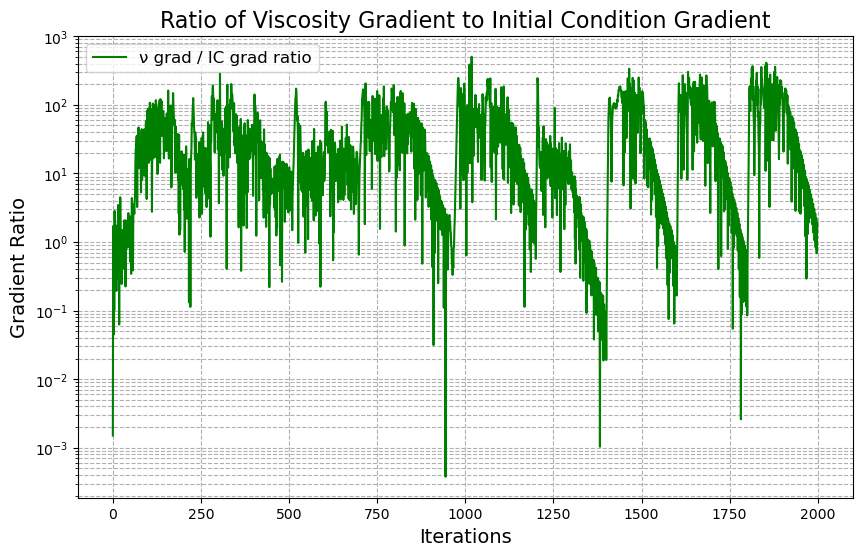

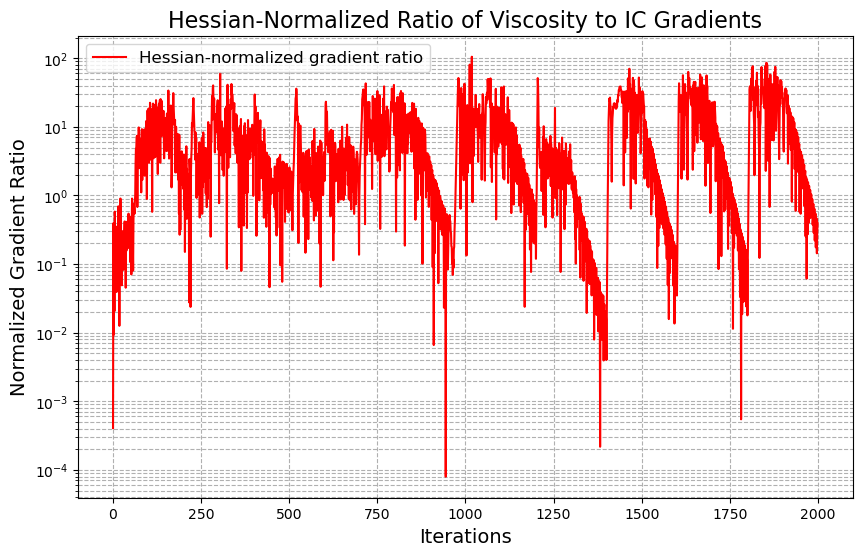

In [12]:
# Plot the ratio of viscosity to initial condition gradients
plt.figure(figsize=(10, 6))
grad_ratios = []
for i in range(len(adam_bilo.grad_norm_nu_history)):
    if adam_bilo.grad_norm_u0_history[i] > 0:
        grad_ratios.append(adam_bilo.grad_norm_nu_history[i] / adam_bilo.grad_norm_u0_history[i])
    else:
        grad_ratios.append(0)

plt.semilogy(grad_ratios, 'g-', label='ν grad / IC grad ratio')
plt.grid(True, which="both", ls="--")
plt.xlabel('Iterations', fontsize=14)
plt.ylabel('Gradient Ratio', fontsize=14)
plt.title('Ratio of Viscosity Gradient to Initial Condition Gradient', fontsize=16)
plt.legend(fontsize=12)
plt.show()

# Compute Hessian-normalized gradient ratios
hessian_normed_grads = []
for i in range(len(adam_bilo.grad_norm_nu_history)):
    if i < len(adam_bilo.H_outer_history):
        h_outer = adam_bilo.H_outer_history[i]
    else:
        h_outer = adam_bilo.H_outer
        
    if i < len(adam_bilo.H_inner_history):
        h_inner = adam_bilo.H_inner_history[i]
    else:
        h_inner = adam_bilo.H_inner
        
    if adam_bilo.grad_norm_u0_history[i] > 0 and h_inner > 0 and h_outer > 0:
        normed_nu = adam_bilo.grad_norm_nu_history[i] / h_outer
        normed_u0 = adam_bilo.grad_norm_u0_history[i] / h_inner
        hessian_normed_grads.append(normed_nu / normed_u0)
    else:
        hessian_normed_grads.append(0)

plt.figure(figsize=(10, 6))
plt.semilogy(hessian_normed_grads, 'r-', label='Hessian-normalized gradient ratio')
plt.grid(True, which="both", ls="--")
plt.xlabel('Iterations', fontsize=14)
plt.ylabel('Normalized Gradient Ratio', fontsize=14)
plt.title('Hessian-Normalized Ratio of Viscosity to IC Gradients', fontsize=16)
plt.legend(fontsize=12)
plt.show()